In [1]:
import pandas as pd
import numpy as np
import math
import re
import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from AucModule import calcAUC

In [2]:
data = pd.read_csv('data/train_new.csv')
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [3]:
data.dropna(thresh = 60, inplace = True)

In [4]:
data.dropna(subset=['Y'], inplace = True)

In [5]:
# fillna with means
for i in range(1, 73):
    data_col = data['X%s'%i].fillna(data['X%s'%i].mean())
    data['X%s'%i] = data_col

In [6]:
# woe
woe = {}
woel = []
good_t = sum(data['Y']==1)
bad_t = sum(data['Y']==0)
for i, v in data.X13.items():
    good = 0
    bad = 0
    if woe.get(v) != None:
        woel.append(woe[v])
    else:
        for j, vj in data.X13.items():
            if vj == v:
                if data.Y[j] == 1:
                    good += 1
                else:
                    bad += 1
        woel.append(math.log((good/good_t+0.1)/(bad/bad_t+0.1)))
        woe[v] = math.log((good/good_t+0.1)/(bad/bad_t+0.1))
data["woel"] = woel

In [7]:
# cross feature
def add_cross_feature(data,feature1,feature2):
    comb_index = data[[feature1,feature2]].drop_duplicates()
    comb_index[feature1+'_'+feature2]=data[feature1]+data[feature2]
    data = pd.merge(data, comb_index, 'left', on=[feature1,feature2])
    return data

In [8]:
data = add_cross_feature(data,'X23','X34')
data = add_cross_feature(data,'X36','X37')

In [9]:
# split test data and train data
x = pd.concat([data.iloc[:, :72],data.iloc[:, [74]]], axis = 1)
#x = data.iloc[:, :72]
y = data.iloc[:, [72]]           # here is an error (73->72)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [11]:
# standard
x_train_arr = np.array(x_train)
x_test_arr = np.array(x_test)
s1 = StandardScaler()
s2 = StandardScaler()
s1.fit(x_train_arr)
x_train_stand = s1.transform(x_train_arr)
s2.fit(x_test_arr)
x_test_stand = s2.transform(x_test_arr)

In [12]:
parameters = {
    'learning_rate': [0.01,0.05,0.1],
}

gbm = lgb.LGBMClassifier(objective='binary',
                        is_unbalance = True,
                        metric = 'auc',
                        max_depth = 6,
                        num_leaves = 30,
                        learning_rate = 0.1,
                        feature_fraction = 0.7,
                        min_child_samples = 25,
                        min_child_weight = 0.001,
                        bagging_fraction = 1,
                        bagging_freq = 2,
                        reg_alpha = 0.001,
                        reg_lambda = 8,
                        cat_smooth = 0,
                        num_iterations = 200,
                        )
gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='roc_auc', cv=3)
gsearch.fit(x_train, y_train)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分：{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
参数的最佳取值:{'learning_rate': 0.1}
最佳模型得分：0.7489216507606492
[0.72702275 0.74732838 0.74892165]
[{'learning_rate': 0.01}, {'learning_rate': 0.05}, {'learning_rate': 0.1}]


In [13]:
prey = gsearch.predict(x_test)

In [15]:
print("auc_score: %s" % calcAUC(y_test.Y,prey))

auc_score: 0.6812870753574978


In [15]:
name = ["id", "predict"]
list = []
for i in range(prey.shape[0]):
    list.append([x_test.index[i], prey[i]])
pred = pd.DataFrame(columns=name, data=list)

In [16]:
pred.to_csv("./result/lightgbm")

[LightGBM] [Info] Number of positive: 11091, number of negative: 20330
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11727
[LightGBM] [Info] Number of data points in the train set: 31421, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352980 -> initscore=-0.605964
[LightGBM] [Info] Start training from score -0.605964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

<Figure size 864x432 with 0 Axes>

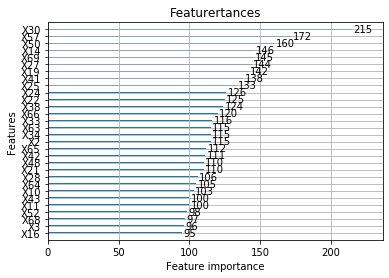

In [43]:
lgb_parameters = {
    'objective':'binary',
    'is_unbalance': True,
    'metric': 'auc',
    'max_depth': 6,
    'num_leaves': 30,
    'learning_rate': 0.1,
    'feature_fraction': 0.7,
    'min_child_samples': 25,
    'min_child_weight': 0.001,
    'bagging_fraction': 1,
    'bagging_freq': 2,
    'reg_alpha': 0.001,
    'reg_lambda': 8,
    'cat_smooth': 0,
    'num_iterations': 200
}
lgb_train = lgb.Dataset(x_train, y_train)
model = lgb.train(lgb_parameters, lgb_train)
plt.figure(figsize=(12,6))
lgb.plot_importance(model, max_num_features=30)
plt.title("Featurertances")
plt.show()